# Algorithm

---------

## Pseudocode:

#### Inputs:
* img_stack
* z_dim, y_dim, x_dim

#### Psuedocode:
For every z_slice in the image stack:

1. Adaptive Threshold
2. Otsu's binarization to get binary image
3. Perform morphological erosion with kernal of radius of 5 voxels
4. Perform morphological opening with kernal of radius of 5 voxels
5. Get connected components using union-find
6. Compute centroids of each component

TODO: k-means for segmentation refinement
    

In [164]:
# for z_slice in img_stack:
#     thresh_value = threshold_otsu(z_slice) / 2
#     z_slice = z_slice > thresh_value
#     z_slice = adaptive_threshold(z_slice)
#     # using a disk shaped kernal of radius 2 pixels
#     z_slice = erosion(z_slice)  
#     z_slice = opening(z_slice)
    
#     components = get_connected_components(z_slice)
#     centroids = get_component_centroids(z_slice)
    
#     # get median of cc's with area above 100 pixels
#     median_area = find_component_median(components)
#     suspect_components = get_components_above_median_area(components)
#     for compenent in suspect_compenents:
#         n = round(component.area / median_area) # number of suspected components
#         k_possibilities = [1, n, n + 1, n-1]
#         potential_components = dictionary
#         for k in k_possibilities:
#             potential_components[k] = k_means(component, k)
#         best_segmentation_components
#         component = best_segmentation_components # updating the component list

### Relevant Links:

[otsu](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html)

[otsu explanation](https://en.wikipedia.org/wiki/Otsu's_method)

---

[adaptive_threshold](http://scikit-image.org/docs/0.12.x/auto_examples/segmentation/plot_threshold_adaptive.html)

[local_threshold](https://github.com/scikit-image/scikit-image/blob/master/skimage/filters/thresholding.py)

---

[morphological transformations skimage](http://scikit-image.org/docs/dev/api/skimage.morphology.html)

[morphological transformations explaination](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html)

---

[labelling connected components](http://www.scipy-lectures.org/packages/scikit-image/auto_examples/plot_labels.html)

[labeling](http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.label)

---

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu, threshold_local
from skimage.morphology import disk, binary_erosion, binary_opening, label
from skimage.measure import regionprops

import SimpleITK as sitk
import numpy as np

from tifffile import imsave, imread

import pickle

# Preprocessing

In [2]:
img_stack = imread('s3617_tifffile.tif')
print('(z, y, x):')
print(img_stack.shape)

(z, y, x):
(100, 1000, 1000)


In [3]:
(z_dim, y_dim, x_dim) = img_stack.shape
z_slice = img_stack[77,:,:]

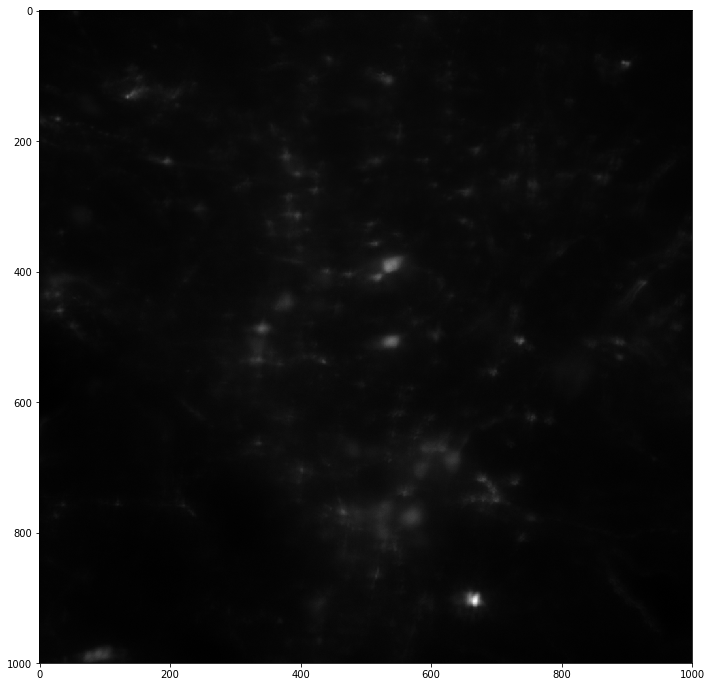

In [11]:
plt.figure(figsize=(12, 12))

# plt.imshow(z_slice, cmap='gray')
plt.imshow(z_slice, cmap=plt.cm.gray)

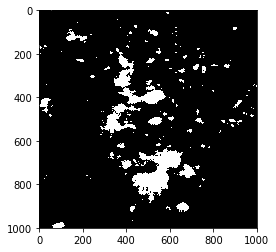

In [10]:
otsu_thresh_value = threshold_otsu(z_slice)
otsu_thresh = z_slice > otsu_thresh_value

plt.imshow(otsu_thresh, cmap=plt.cm.gray)

In [27]:
# Thresholding: making all voxels with intensity less than half of otsu's 0.
thresh_value = threshold_otsu(z_slice)
# z_slice = z_slice > thresh_value

initial_thresholding = np.zeros(z_slice.shape)

for i in range(0, x_dim):
    for j in range(0, y_dim):
        initial_thresholding[j, i] = 0 if z_slice[j, i] < thresh_value else z_slice[j, i]

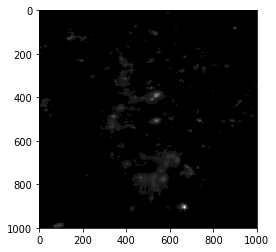

In [28]:
plt.imshow(initial_thresholding, cmap=plt.cm.gray)

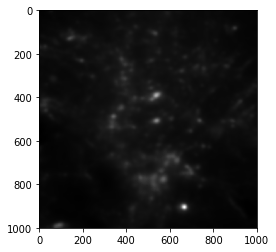

In [33]:
initial_thresholding = np.copy(z_slice)

# Adaptive thresholding. After this step, images should be binary.
block_size = 35
local_thresh = threshold_local(initial_thresholding, block_size)

plt.imshow(local_thresh, cmap=plt.cm.gray)

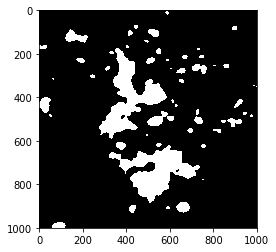

In [34]:
otsu_thresh_value = threshold_otsu(local_thresh)
otsu_thresh = local_thresh > otsu_thresh_value

plt.imshow(otsu_thresh, cmap=plt.cm.gray)

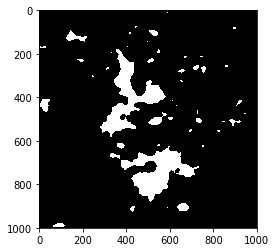

In [35]:
# Morphological tranformations using a disk shaped kernal of radius 2 pixels
erosion = binary_erosion(otsu_thresh, disk(5))
plt.imshow(erosion, cmap=plt.cm.gray)

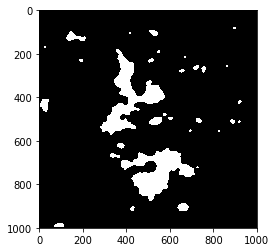

In [36]:
opening = binary_opening(erosion, disk(5))
plt.imshow(opening, cmap=plt.cm.gray)

# Getting Connected Components

In [18]:
components, num_components = label(opening, return_num=True, connectivity=2)
print(components)
print('num_components: ' + str(num_components))

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
num_components: 31


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


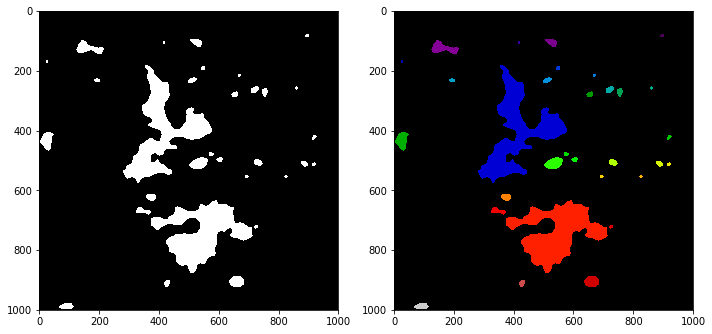

In [19]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(opening, cmap='gray')
# plt.axis('off')
plt.subplot(122)
plt.imshow(components, cmap='spectral')
# plt.axis('off')

plt.tight_layout()
plt.show()

# Getting centroids of connected components

In [20]:
# Getting centroids of connected components
props = regionprops(components)
print(len(props))

31


In [21]:
centroids = []
for prop in props:
    centroids.append(prop.centroid)
    print(prop.centroid)
    
centroids = np.array(centroids)

(82.415254237288138, 896.46610169491521)
(104.56975228161669, 527.02868318122557)
(123.80643699002719, 164.41749773345421)
(104.0, 418.0)
(169.0, 26.0)
(401.74418871606497, 412.91339034609422)
(190.54913294797689, 547.68208092485554)
(215.0, 669.0)
(230.78518518518518, 512.58024691358025)
(230.87619047619049, 194.10952380952381)
(262.68930041152265, 721.36625514403295)
(257.0, 861.0)
(270.74704491725771, 754.85815602836874)
(277.93072289156629, 655.42771084337346)
(432.83141131246566, 26.289950576606259)
(421.30208333333331, 920.01041666666663)
(478.16161616161617, 575.030303030303)
(496.22968197879857, 603.97526501766788)
(508.81267217630852, 534.83360881542694)
(505.73398058252428, 732.07766990291259)
(510.18023255813955, 887.00872093023258)
(511.88805970149252, 918.94776119402979)
(552.625, 694.14285714285711)
(553.0, 826.0)
(621.83030303030307, 374.93787878787879)
(741.21913738931732, 542.57263638960296)
(668.70580110497235, 347.34944751381215)
(721.5, 725.5)
(904.20194174757285, 6

In [22]:
print(centroids[:,0])

[  82.41525424  104.56975228  123.80643699  104.          169.
  401.74418872  190.54913295  215.          230.78518519  230.87619048
  262.68930041  257.          270.74704492  277.93072289  432.83141131
  421.30208333  478.16161616  496.22968198  508.81267218  505.73398058
  510.18023256  511.8880597   552.625       553.          621.83030303
  741.21913739  668.7058011   721.5         904.20194175  910.53421053
  986.22192152]


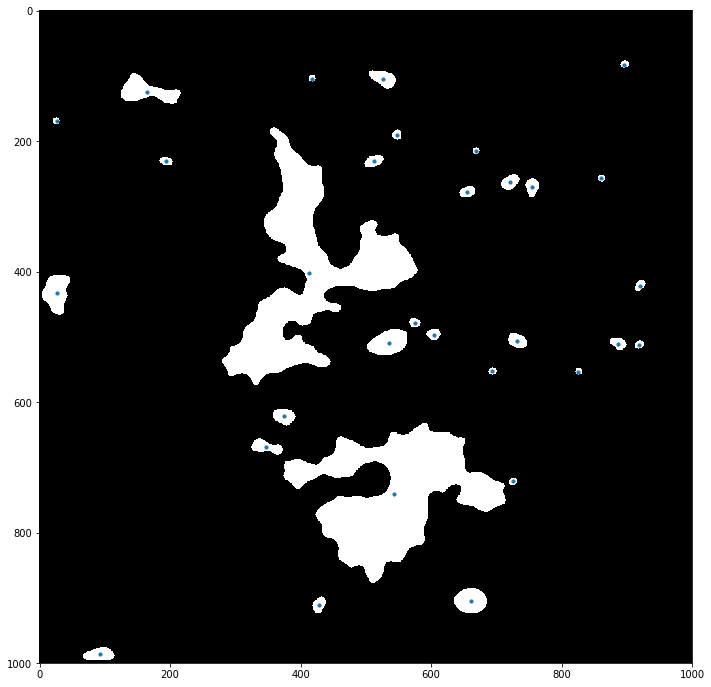

In [23]:
plt.figure(figsize=(12, 12))

plt.imshow(opening, cmap='gray')
plt.scatter(centroids[:,1], centroids[:,0], s=10)

plt.show()

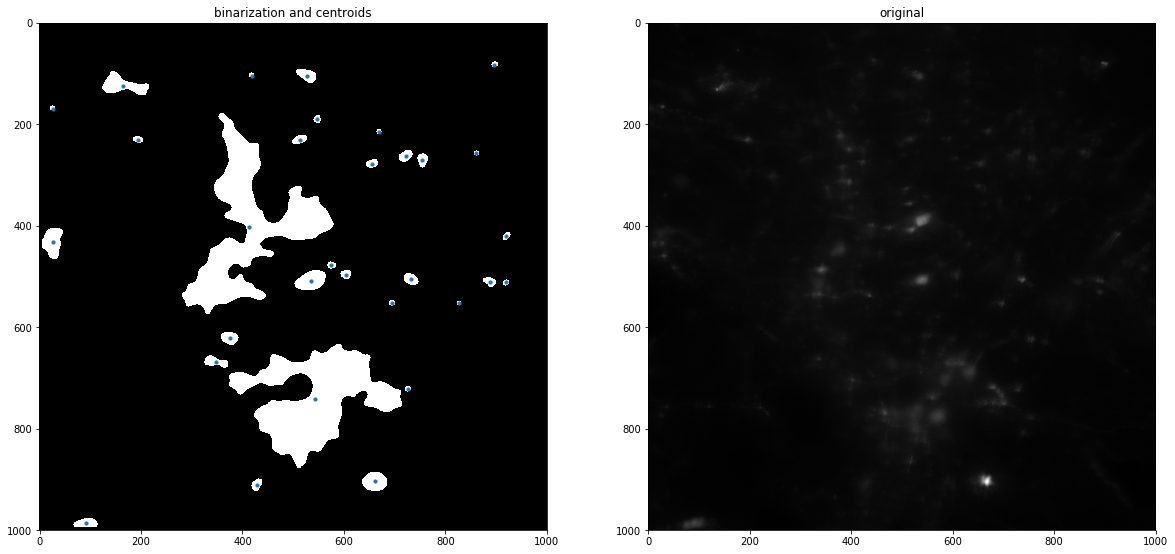

In [26]:
plt.figure(figsize=(20, 20))

plt.subplot(1,2,1)
plt.title('binarization and centroids')
plt.imshow(opening, cmap='gray')
plt.scatter(centroids[:,1], centroids[:,0], s=10)
# plt.show()

plt.subplot(1,2,2)
plt.title('original')
plt.imshow(z_slice, cmap=plt.cm.gray)

In [119]:
props[0].coords

array([[ 78, 780],
       [ 78, 781],
       [ 78, 782],
       [ 78, 783],
       [ 79, 777],
       [ 79, 778],
       [ 79, 779],
       [ 79, 780],
       [ 79, 781],
       [ 79, 782],
       [ 79, 783],
       [ 79, 784],
       [ 79, 785],
       [ 79, 786],
       [ 80, 776],
       [ 80, 777],
       [ 80, 778],
       [ 80, 779],
       [ 80, 780],
       [ 80, 781],
       [ 80, 782],
       [ 80, 783],
       [ 80, 784],
       [ 80, 785],
       [ 80, 786],
       [ 80, 787],
       [ 81, 776],
       [ 81, 777],
       [ 81, 778],
       [ 81, 779],
       [ 81, 780],
       [ 81, 781],
       [ 81, 782],
       [ 81, 783],
       [ 81, 784],
       [ 81, 785],
       [ 81, 786],
       [ 81, 787],
       [ 82, 776],
       [ 82, 777],
       [ 82, 778],
       [ 82, 779],
       [ 82, 780],
       [ 82, 781],
       [ 82, 782],
       [ 82, 783],
       [ 82, 784],
       [ 82, 785],
       [ 82, 786],
       [ 82, 787],
       [ 83, 775],
       [ 83, 776],
       [ 83,

# Pickling the region properties.

In [128]:
with open('props_60.pkl', 'wb') as f:
    pickle.dump(props, f)

In [129]:
ps = pickle.load(open("props_60.pkl", "rb"))

In [130]:
print(ps)

[<skimage.measure._regionprops._RegionProperties object at 0x7fb86c1ae350>, <skimage.measure._regionprops._RegionProperties object at 0x7fb86c2cc690>, <skimage.measure._regionprops._RegionProperties object at 0x7fb86c2cc550>, <skimage.measure._regionprops._RegionProperties object at 0x7fb86c2cc810>, <skimage.measure._regionprops._RegionProperties object at 0x7fb86c2cc390>, <skimage.measure._regionprops._RegionProperties object at 0x7fb86c2cc4d0>, <skimage.measure._regionprops._RegionProperties object at 0x7fb86c2cc410>, <skimage.measure._regionprops._RegionProperties object at 0x7fb86c2cc650>, <skimage.measure._regionprops._RegionProperties object at 0x7fb86c2cc3d0>, <skimage.measure._regionprops._RegionProperties object at 0x7fb86c2cc5d0>]


In [131]:
for p in ps:
    print(p.centroid)

(83.761194029850742, 781.5)
(296.68823529411765, 416.02941176470586)
(318.7454268292683, 369.3734756097561)
(400.64160401002505, 602.69172932330832)
(512.05405405405406, 692.85749385749386)
(532.34349827387803, 182.84407364787111)
(555.00535395597853, 330.1921475312314)
(654.73400503778339, 168.40755667506298)
(644.86956521739125, 649.8478260869565)
(805.38051044083522, 659.18793503480276)


# Testing out function

In [136]:
from detector import detect_blobs

In [133]:
# detect_blobs('s3617_tifffile.tif', 'z_comps', True)
detect_blobs('s3617_tifffile.tif')

num_components: 11
num_components: 20
num_components: 28
num_components: 24
num_components: 22
num_components: 26
num_components: 27
num_components: 28
num_components: 16
num_components: 4
num_components: 8
num_components: 7
num_components: 5
num_components: 11
num_components: 12
num_components: 10
num_components: 10
num_components: 11
num_components: 9
num_components: 2
num_components: 12
num_components: 7
num_components: 7
num_components: 23
num_components: 15
num_components: 8
num_components: 6
num_components: 5
num_components: 11
num_components: 16
num_components: 16
num_components: 12
num_components: 15
num_components: 13
num_components: 14
num_components: 13
num_components: 5
num_components: 2
num_components: 3
num_components: 16
num_components: 6
num_components: 8
num_components: 7
num_components: 4
num_components: 10
num_components: 18
num_components: 10
num_components: 7
num_components: 7
num_components: 7
num_components: 2
num_components: 3
num_components: 4
num_components: 5

In [139]:
z_props = pickle.load(open("z_props.pkl", "rb"))

In [140]:
p_60 = z_props[60]

In [141]:
for p in p_60:
    print(p.centroid)

(83.761194029850742, 781.5)
(296.68823529411765, 416.02941176470586)
(318.7454268292683, 369.3734756097561)
(400.64160401002505, 602.69172932330832)
(512.05405405405406, 692.85749385749386)
(532.34349827387803, 182.84407364787111)
(555.00535395597853, 330.1921475312314)
(654.73400503778339, 168.40755667506298)
(644.86956521739125, 649.8478260869565)
(805.38051044083522, 659.18793503480276)
